In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# List the columns from the measurement table
session.query(Measurement).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x228ba6ef850>,
 'station': 'USC00519397',
 'tobs': 65.0,
 'prcp': 0.08,
 'date': '2010-01-01',
 'id': 1}

In [10]:
# List the columns from the station table
session.query(Station).first().__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x228b5d8de50>,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

## Bonus Challenge Assignment: Temperature Analysis II

In [11]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
#print(calc_temps('2012-02-28', '2012-03-05'))

In [12]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
trip_start = '2017-08-01'
trip_end = '2017-08-07'

trip_temps = pd.DataFrame(calc_temps(trip_start, trip_end), columns = ["Min", "Avg", "Max"])
trip_temps

,Min,Avg,Max
0,72.0,79.25,83.0


In [13]:
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y_error = trip_temps["Max"] - trip_temps["Min"]
y_error

0    11.0
dtype: float64

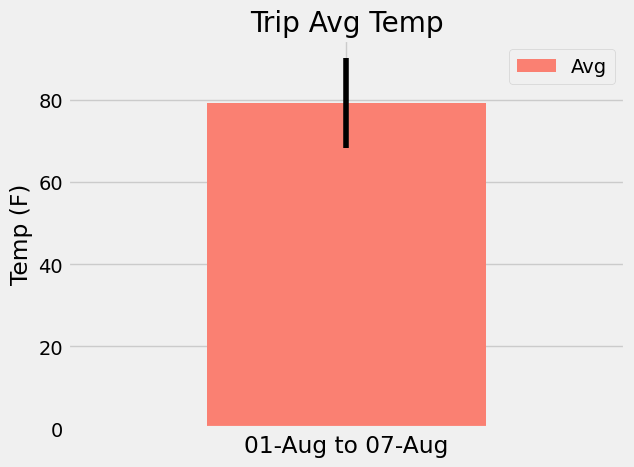

In [14]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_temps.plot(kind="bar", y="Avg", yerr=y_error, color="salmon",)
plt.title("Trip Avg Temp")
plt.xlabel("01-Aug to 07-Aug")
plt.ylabel("Temp (F)")
plt.tick_params(labelbottom=False)
plt.show()

### Daily Rainfall Average

In [15]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_station = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp),\
                                 Station.latitude, Station.longitude, Station.elevation).\
                    filter(Measurement.station == Station.station).\
                    filter(Measurement.date >= trip_start).\
                    filter(Measurement.date <= trip_end).\
                    group_by(Measurement.station).\
                    order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_station
                    

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 0.36, 21.3331, -157.8025, 152.4),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 0.22, 21.5213, -157.8374, 7.0),
 ('USC00519281', 'WAIHEE 837.5, HI US', 0.06, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 0.04, 21.2716, -157.8168, 3.0),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 0.0, 21.33556, -157.71139, 19.5)]

In [16]:
# Create a dataframe to hold the rainfall per station data
trip_rain_station = pd.DataFrame(rainfall_station, columns = ["station", "name", "prcp", "latitude", "longitude", "elevation"])
trip_rain_station

,station,name,prcp,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.36,21.33310,-157.80250,152.4
1,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.22,21.52130,-157.83740,7.0
2,USC00519281,"WAIHEE 837.5, HI US",0.06,21.45167,-157.84889,32.9
3,USC00519397,"WAIKIKI 717.2, HI US",0.04,21.27160,-157.81680,3.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5


### Daily Temperature Normals

In [17]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
# daily_normals("01-01")

In [18]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start = start_date, end = end_date)
print(f"trip_dates: {trip_dates}")

# Strip off the year and save a list of strings in the format %m-%d
trip_day_mth = trip_dates.strftime("%m-%d")
print(f"trip_day_mth: {trip_day_mth}")

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for day in trip_day_mth:
    date_temp = daily_normals(day)
    normals.append(date_temp)
    
print(f"normals: {normals}")

trip_dates: DatetimeIndex(['2017-08-01', '2017-08-02', '2017-08-03', '2017-08-04',
               '2017-08-05', '2017-08-06', '2017-08-07'],
              dtype='datetime64[ns]', freq='D')
trip_day_mth: Index(['08-01', '08-02', '08-03', '08-04', '08-05', '08-06', '08-07'], dtype='object')
normals: [[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]]


In [19]:
# Create a dictionary to hold the trip dates and temperature calculations
trip_temp_dict = {trip_day_mth[i]: normals[i][0] for i in range(len(normals))}
trip_temp_dict

{'08-01': (67.0, 75.54, 83.0),
 '08-02': (68.0, 75.60377358490567, 84.0),
 '08-03': (70.0, 76.61111111111111, 85.0),
 '08-04': (69.0, 76.71153846153847, 84.0),
 '08-05': (69.0, 76.14814814814815, 82.0),
 '08-06': (67.0, 76.25, 83.0),
 '08-07': (71.0, 77.15686274509804, 83.0)}

In [20]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_temp = pd.DataFrame.from_dict(trip_temp_dict, orient="index", columns=["tmin","tavg","tmax"])
trip_temp

,tmin,tavg,tmax
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


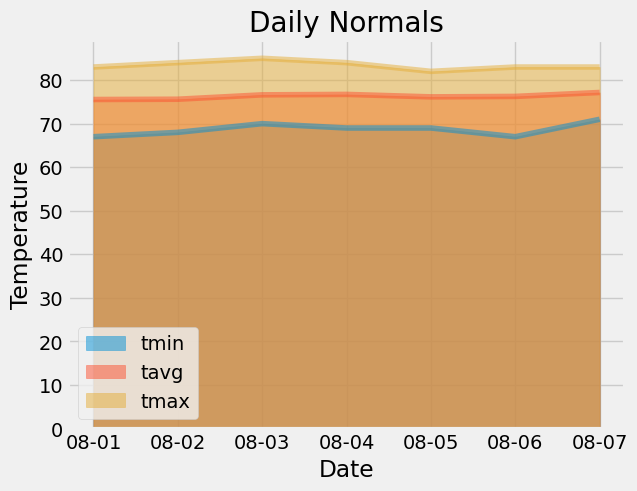

In [21]:
# Plot the daily normals as an area plot with `stacked=False`
trip_temp.plot.area(stacked=False)
plt.title('Daily Normals')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.show()

## Close Session

In [22]:
session.close()